In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('ggplot')
np.random.seed(0)

In [2]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    latest update = checked the days again, it works perfectly splendid
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia  

In [3]:
def sum_last14(casos_por_dia):
    #latest update = checked the days again, it works perfectly splendid
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [4]:
def first_solution(n_t,a,b,c,d,e):
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a*n_t[i-6,1] + b*n_t[i-5,1] + c*n_t[i-4,1] + d*n_t[i-3,1] + e*n_t[i-2,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((n_t[i-1,1] + n_t[i,1] + n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    r_def = np.copy(r_t_seven)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    return p_t[:-6]
    
    

In [5]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)

In [6]:
data = pd.read_csv("casos_Bariloche.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [7]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-03-09 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


In [8]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)
max(fecha_sintomas)

295

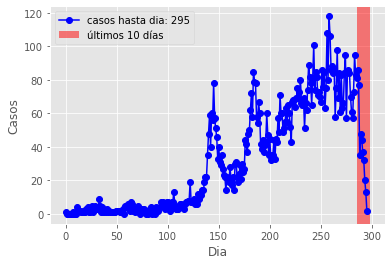

In [9]:
casos_por_dia = new_cases_per_day(fecha_sintomas,graph = True,ret=True)
cases = np.copy(casos_por_dia)

In [10]:
predicted = first_solution(casos_por_dia,1,1,1,0,0)

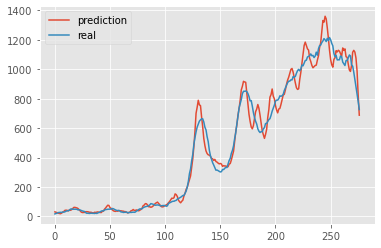

In [11]:
plt.figure()
plt.plot(predicted,label='prediction')
res = sum_last14(cases)[:,1]
plt.plot(res[19:],label='real')
plt.legend()
smse1 = np.linalg.norm(predicted-res[19:])

In [12]:
print(res[19:].shape)
print(predicted.shape)

(277,)
(277,)


In [13]:
p0 = 1,1,1,0,0
k, cov = curve_fit(first_solution, casos_por_dia, res[19:], p0)

In [14]:
k

array([1.44624115e+00, 1.34974633e-01, 5.90692099e-07, 3.32220254e-01,
       1.09374219e+00])

In [15]:
np.sqrt(abs(cov))

array([[0.33971631, 0.40101815, 0.07707073, 0.23528695, 0.11710026],
       [0.40101815, 0.52785254, 0.22970606, 0.32285785, 0.19291059],
       [0.07707073, 0.22970606, 0.28465456, 0.1872703 , 0.02441603],
       [0.23528695, 0.32285785, 0.1872703 , 0.4253676 , 0.31123235],
       [0.11710026, 0.19291059, 0.02441603, 0.31123235, 0.27014903]])

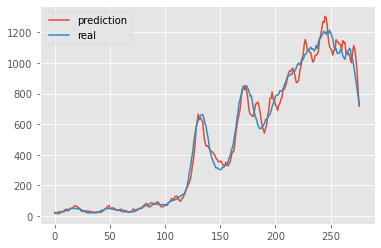

In [16]:
predicted = first_solution(casos_por_dia,k[0],k[1],k[2],k[3],k[4])
plt.figure()
plt.plot(predicted,label='prediction')
res = sum_last14(cases)[:,1]
plt.plot(res[19:],label='real')
plt.legend()
smse2 = np.linalg.norm(predicted-res[19:])

In [17]:
smse2-smse1

-190.55507136250344

In [18]:
print(smse1,smse2)

1027.6125745260238 837.0575031635203
